## Sea Performance Model

The performace of the system as a whole can be broken down into three components: 1) The amount of time it takes
to read the data from Lustre, 2) the amount of time it takes to read and write the required data to memory, and 3) the amount of time it takes to read and write the data to disk. 

First, we shall devise a simplified performance model for Lustre alone, as this will give us an upper bound to the 
added performance of Sea. We describe Lustre's performance as follows:

$$ M_{l} =  \frac{DI}{\min{(B_{n}N, B_{lr}O)}} + \frac{DI}{\min{(B_{n}N, B_{lw}O)}}$$

$\text{Where,}$<br>
$M_{l}$ represents Lustres makespan<br>
$D$ is the size of the input dataset<br>
$I$ is the total number of iterations<br>
$O$ is the number of Lustre OSTs<br>
$N$ is the number of compute nodes<br>
$B_{n}$ is the network bandwidth<br>
$B_{lr}$ is a Lustre OST's read bandwidth<br>
$B_{lw}$ is a Lustre OST's write bandwidth<br>

Essentially, the makespan can be descriped as the total time it takes to read and write all the data to and from Lustre. Lustre can have a bottleneck in one of two places: within the network transfer, due to limited network bandwidth, or the OSTs, due to collective disk bandwidths. It is important to account for both of these bottlenecks as they may fluctuate depending on the number of compute nodes required for a given experiment.


From here, we can expand the model to calculate the performance of Sea. To simplify our understanding of the model, we will break it up into the involved storage components, namely, Lustre, local disk and tmpfs. For simplicity's sake, we will ignore flushing in the model.

The makespan of the Lustre component of Sea can be calculated as follows:

$$M_{sl} = \frac{D}{\min{(B_{n}N, B_{lr}O)}}$$

Where,<br>
$M_{sl}$ is the makespan of the Sea's Lustre component<br>
$D$ is the size of the input dataset<br>
$N$ is the number of compute nodes<br>
$O$ is the number of Lustre OSTs<br>
$B_{n}$ is the network bandwidth<br>
$B_{lr}$ is a Lustre OST's read bandwidth<br>

Unlike the Lustre makespan model, we do not account for Lustre write time here. We choose to make the assumption that all the data can fit on local disks, and the data destined for Lustre will be flushed asynchronously by Sea other than written directly.

The makespan of the tmpfs component of Sea can be described as follows:

$$M_{sm} = \frac{\min(D(I - 1), (S - Fn)N)}{B_{mr}N} + \frac{\min(DI, (S - Fn)N)}{B_{mw}N}$$

Where,<br>
$M_{sm}$ is the makespan of Sea's memory component<br>
$D$ is the size of the input dataset<br>
$I$ is the number of iterations<br>
$S$ is the amount of available tmpfs storage<br>
$F$ is the size of an individual file<br>
$n$ is the number of threads per node<br>
$N$ is the number of compute nodes<br>
$B_{mr}$ is the read bandwidth of tmpfs<br>
$B_{mw}$ is the write bandwidth of tmpfs<br>

The maximum number of files that can be read from memory is all read data, with the exception of the first read, which can only occur from Lustre. However, depending on the data size, it is very likely that all read data may not be stored in memory, as tmpfs storage is expected to be limited. Sea determines that there is sufficient tmpfs space to execute a write if there is at least enough space for all parallel threads to write a file on tmpfs.

The makespan of disk component of Sea can be described as follows:

$$M_{sd} = \frac{D(I - 1) - \min(D(I - 1), (S - Fn)N)}{B_{dr}dN} + \frac{DI - \min(DI, (S - Fn)N)}{B_{dw}dN}$$

Where,<br>
$M_{sd}$ is the makespan of Sea's disk component<br>
$D$ is the size of the input dataset<br>
$I$ is the number of iterations<br>
$S$ is the amount of available tmpfs storage<br>
$F$ is the size of an individual file<br>
$n$ is the number of threads per node<br>
$N$ is the number of compute nodes<br>
$d$ is the number of disks per compute node<br>
$B_{dr}$ is the disk read bandwidth<br>
$B_{dw}$ is the disk write bandwidth<br>

Here the number read and written to disk is calculate as the total amount of data to be read and written from local disk minus the amount of read and written data that has been stored in memory. As the parallel bandwidth of disk on a single node may fluctuate with the number of disks uses, the distributed bandwidth of local disk must be multiplied by the number of compute nodes and disks used.

Sea's bandwidth can therefore be calculated as a sum of the individual components. More formally, the makespan of an incrementaion pipeline running alongside Sea can be described as as:

$$M_{total} = M_{sl} + M_{sm} + M_{sd}$$

Where,<br>
$M_{total}$ is the total makespan<br>
$M_{sl}$ is the makespan of the Lustre component in Sea<br>
$M_{sm}$ is the makespan of the memory component in Sea<br>
$M_{sd}$ is the makespan of the disk component in Sea<br>

### The Linux Page Cache Model


The aforementioned models are imperfect in that they describe a scenario in which data outside of Sea is not cached in memory. This is an unlikely case as many systems leverage, by default, the Page cache in order speed up I/O to non-volatile storage media.

The page cache model for reads can be described as follows:

$$M_{pread} = \frac{\min(N(I-1)(A - Fn), D(I-1))}{B_{mr}N}$$

Where,<br>
$M_{pread}$ is the makespan of a read occurring entirely in page cache<br>
$N$ is the number of compute nodes<br>
$I$ is the number of iterations<br>
$A$ is the amount of available memory<br>
$F$ is the file size<br>
$n$ is the number of threads in a node<br>
$D$ is the input dataset size<br>
$B_{mr}$ is the bandwidth of a memory read<br>

A-Fn is the amount of available memory that will not be occupied by anonymous memory.... need to explain more here.

The page cache model for writes can be described as follows:

$$M_{pwrite} = \frac{\min(CNI(A - Fn), DI)}{B_{mw}N}$$

Where,<br>
$M_{wread}$ is the makespan of a write occurring entirely in page cache<br>
$N$ is the number of compute nodes<br>
$I$ is the number of iterations<br>
$C$ is the percentage of page cache that can be occupied by dirty data
$A$ is the amount of available memory<br>
$F$ is the file size<br>
$n$ is the number of threads in a node<br>
$D$ is the input dataset size<br>
$B_{mw}$ is the bandwidth of a memory write<br>


Therefore, the Lustre makespan model can be rewritten as:

$$M_{l} =  \underbrace{{\frac{D}{\min{(B_{n}N, B_{lr}O)}}}}_\text{Lustre initial read} + \underbrace{\frac{\min(N(I-1)(A - Fn), D(I-1))}{B_{mr}N}}_\text{cached reads} + \underbrace{\frac{D(I-1) - \min(N(I-1)(A - Fn), D(I-1))}{\min{(B_{n}N, B_{lr}O)}}}_\text{non-cached reads}+ \underbrace{\frac{\min(CNI(A - Fn), DI)}{B_{mw}N}}_\text{cached writes} + \underbrace{\frac{DI - \min(CNI(A - Fn), DI)}{\min{(B_{n}N, B_{lw}O)}}}_\text{non-cached writes}$$

Where,<br>
$M_{l}$ represents Lustres makespan<br>
$D$ is the size of the input dataset<br>
$I$ is the total number of iterations<br>
$O$ is the number of Lustre OSTs<br>
$N$ is the number of compute nodes<br>
$C$ is the percentage of page cache that can be occupied by dirty data
$A$ is the amount of available memory<br>
$F$ is the file size<br>
$n$ is the number of threads in a node<br>
$B_{n}$ is the network bandwidth<br>
$B_{lr}$ is a Lustre OST's read bandwidth<br>
$B_{lw}$ is a Lustre OST's write bandwidth<br>
$B_{mr}$ is the bandwidth of a memory read<br>
$B_{mw}$ is the bandwidth of a memory write<br>




In [1]:
## Model fixed variables

num_files=1000
file_size=617
tmpfs_size=126*1024
a_mem=256*1024
dirty_ratio=0.4

# bandwidths
disk_r = 510
disk_w = 426

mem_r = 6760
mem_w = 2560

lustre_r = 200
lustre_w = 191
lustre_disks = 44

network_bw = 4096 #1026

n_threads = 6
n_iterations = 5
n_nodes = 5
n_disks = 6


In [2]:
## Makespan models

n_written = lambda n_files, n_iterations: n_files * n_iterations # also number of files read from lustre

# we assume that the files prioritized to memory will be read, which is not necessarily true
input_size = lambda n_files, file_size: n_files * file_size

# local read and writes
local_read = (lambda
    input_size,
    n_iterations : input_size * (n_iterations - 1)) # first files read from lustre, last files not read
local_write = (lambda
    input_size,
    n_iterations : input_size * n_iterations)

# current setting for writing to tmpfs/disks
avail_tmpfs = (lambda
    n_nodes,
    n_threads : tmpfs_size - (file_size * n_threads) * n_nodes)
read_mem = (lambda
    in_size,
    n_its,
    n_nodes, 
    nthreads : min(local_read(in_size, n_its), avail_tmpfs(n_nodes, nthreads)))
write_mem = (lambda
    in_size,
    n_its,
    n_nodes,
    nthreads : min(local_write(in_size, n_its), avail_tmpfs(n_nodes, nthreads)))

# lustre makespan breakdown
lustre_read = (lambda
    num_read,
    network_bw,
    n_nodes,
    file_size : (num_read * file_size) / min (network_bw * n_nodes, lustre_r * lustre_disks))
lustre_write = (lambda
    num_flushed,
    network_bw,
    n_nodes,
    file_size : (num_flushed * file_size) / min(network_bw * n_nodes, lustre_w * lustre_disks))

# memory makespan break
memory_read = (lambda
    in_size,
    n_its,
    n_nodes,
    n_threads : read_mem(in_size, n_its, n_nodes, n_threads) / (mem_r * n_nodes))
memory_write = (lambda
    in_size,
    n_its,
    n_nodes,
    n_threads : write_mem(in_size, n_its, n_nodes, n_threads) / (mem_w * n_nodes))

# local disk makespan breakdown
# assumes the remainder of data fits on disk -- not necessarily true
disk_read = (lambda
    in_size,
    n_its,
    n_nodes,
    nthreads,
    n_disks: ((local_read(in_size, n_its) - read_mem(in_size, n_its, n_nodes, nthreads)) 
              / (disk_r * n_disks * n_nodes)))
disk_write = (lambda
    in_size,
    n_its,
    n_nodes,
    nthreads,
    n_disks : ((local_write(in_size, n_its) - write_mem(in_size, n_its, n_nodes, nthreads)) 
               / (disk_w * n_disks * n_nodes)))

# **Total makespan**
lustre_mksp = (lambda
    n_files,
    n_its,
    network_bw,
    n_nodes,
    file_size : (lustre_read(n_written(n_files, n_its), network_bw, n_nodes, file_size)
                 + lustre_write(n_written(n_files, n_its), network_bw, n_nodes, file_size)))

sea_mksp = (lambda
    n_files,
    n_its,
    network_bw, 
    n_nodes, 
    file_size,
    n_threads,
    n_disks : (lustre_read(n_files, network_bw, n_nodes, file_size)
               + memory_read(n_files*file_size, n_its, n_nodes, n_threads) 
               + memory_write(n_files*file_size, n_its, n_nodes, n_threads) 
               + disk_read(n_files*file_size, n_its, n_nodes, n_threads, n_disks) 
               + disk_write(n_files*file_size, n_its, n_nodes, n_threads, n_disks)))

# Page cache models
cached_read = (lambda
    n_nodes,
    n_its,
    a_mem,
    file_size,
    n_threads,
    in_data : min(n_nodes * (n_its - 1) * (a_mem - (file_size * n_threads)), in_data * (n_its - 1)))

cached_write = (lambda
    dirty_ratio,
    n_nodes,
    n_its,
    a_mem,
    file_size,
    n_threads,
    in_data: min(dirty_ratio * n_nodes * n_its * (a_mem - (file_size * n_threads)), in_data * n_its))

m_pread = (lambda
    n_nodes,
    n_its,
    a_mem,
    file_size,
    n_threads,
    in_data,
    b_mr : cached_read(n_nodes, n_its, a_mem, file_size, n_threads, in_data) / (b_mr * n_nodes))

m_pwrite = (lambda
    dirty_ratio,
    n_nodes,
    n_its,
    a_mem,
    file_size,
    n_threads,
    in_data,
    b_mw : cached_write(dirty_ratio, n_nodes, n_its, a_mem, file_size, n_threads, in_data) / (b_mw * n_nodes))

# **With PC**
lpc_mksp = (lambda
    n_files,
    n_its,
    network_bw,
    n_nodes,
    file_size,
    a_mem,
    n_threads,
    in_data,
    b_mr,
    dirty_ratio,
    b_mw : (lustre_read(n_written(n_files, 1), network_bw, n_nodes, file_size)
                 + m_pread(n_nodes, n_its, a_mem, file_size, n_threads, in_data, b_mr)
                 + (((in_data * (n_its - 1)) - cached_read(n_nodes, n_its, a_mem, file_size, n_threads, in_data))
                    / min (network_bw * n_nodes, lustre_r * lustre_disks))
                 + m_pwrite(dirty_ratio, n_nodes, n_its, a_mem, file_size, n_threads, in_data, b_mw)
                 + (((n_its * in_data) - cached_write(dirty_ratio, n_nodes, n_its, a_mem, file_size, n_threads, in_data))
                    / min(network_bw * n_nodes, lustre_r * lustre_disks))))


### Model evaluation - Network bandwidth

(0.0, 103.9)

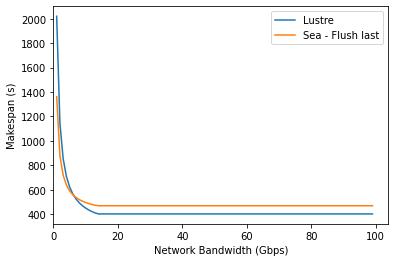

In [3]:
bw = range(128, 100*128, 128)
gbps = [b/128 for b in bw]

lustre = [lpc_mksp(num_files, n_iterations, b, n_nodes, file_size, a_mem, n_threads, num_files*file_size, mem_r, dirty_ratio, mem_w) for b in bw]
sea = [sea_mksp(num_files, n_iterations, b, n_nodes, file_size, n_threads, n_disks) for b in bw]

import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=gbps, y=lustre, label="Lustre")
sns.lineplot(x=gbps, y=sea, label="Sea - Flush last")
plt.xlabel("Network Bandwidth (Gbps)")
plt.ylabel("Makespan (s)")
plt.xlim(0)

### Model evaluation - Number of nodes

Text(0, 0.5, 'Makespan (s)')

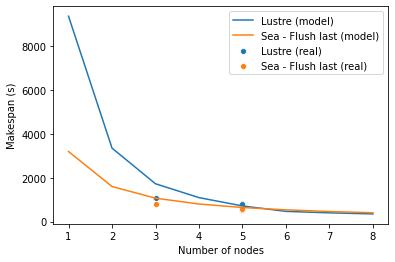

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nodes = range(1,9)
b = 4*128
lustre = [lpc_mksp(num_files, n_iterations, b, n, file_size, a_mem, n_threads, num_files*file_size, mem_r, dirty_ratio, mem_w) for n in nodes]
sea = [sea_mksp(num_files, n_iterations, b, n, file_size, n_threads, n_disks) for n in nodes]

df = pd.read_csv("../results/exp_6t_5i_n35.out")
df["nodes"] = df["experiment"].apply(lambda row: int(row.split('n_')[0].split("_")[-1]))
df["experiment"] = df["experiment"].apply((lambda row: row.split("_")[0] if "lustre" in row else row.split("_")[1]))

df_lustre=df[df["experiment"] == "lustre"]
df_last=df[df["experiment"] == "mem"]

sns.lineplot(x=nodes, y=lustre, label="Lustre (model)")
sns.lineplot(x=nodes, y=sea, label="Sea - Flush last (model)")
sns.scatterplot(data=df_lustre, x="nodes", y="runtime", label="Lustre (real)")
sns.scatterplot(data=df_last, x="nodes", y="runtime", label="Sea - Flush last (real)")
plt.xlabel("Number of nodes")
plt.ylabel("Makespan (s)")

### Model evaluation - Number of disks

Text(0, 0.5, 'Makespan (s)')

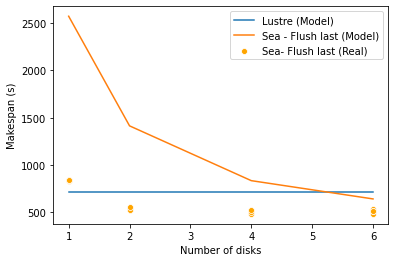

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nodes = 5
bw = 4*8
disks = [1, 2, 4, 6] #range(1, 7)

lustre = [lpc_mksp(num_files, n_iterations, b, nodes, file_size, a_mem, n_threads, num_files*file_size, mem_r, dirty_ratio, mem_w) for d in disks]
sea = [sea_mksp(num_files, n_iterations, b, nodes, file_size, n_threads, d) for d in disks]

df = pd.read_csv("../results/experiment_disks.out")
df = df[(df["experiment"].str.contains("mem"))]
df["disks"] = df["experiment"].apply(lambda name: int(name.split("d_")[0].split("_")[-1]))
df = df.sort_values(by=['disks'])

sns.lineplot(x=disks, y=lustre, label="Lustre (Model)")
sns.lineplot(x=disks, y=sea, label="Sea - Flush last (Model)")
sns.scatterplot(data=df, x="disks", y="runtime", label="Sea- Flush last (Real)", color="orange")
plt.xlabel("Number of disks")
plt.ylabel("Makespan (s)")

### Model evaluation - Number of iterations

(0.0, 20.0)

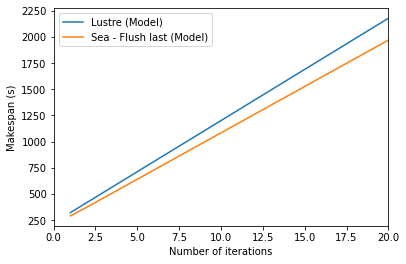

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nodes = 5
bw = 4*8
d = 6
n_iterations = range(1, 21)

lustre = [lpc_mksp(num_files, i, b, nodes, file_size, a_mem, n_threads, num_files*file_size, mem_r, dirty_ratio, mem_w)  for i in n_iterations]
sea = [sea_mksp(num_files, i, b, nodes, file_size, n_threads, d) for i in n_iterations]


sns.lineplot(x=n_iterations, y=lustre, label="Lustre (Model)")
sns.lineplot(x=n_iterations, y=sea, label="Sea - Flush last (Model)")
#sns.scatterplot(data=df, x="disks", y="runtime", label="Sea- Flush last (Real)", color="orange")
plt.xlabel("Number of iterations")
plt.ylabel("Makespan (s)")
plt.xlim(0, 20)

### Model evaluation - Number of files

(0.0, 22499.16625462278)

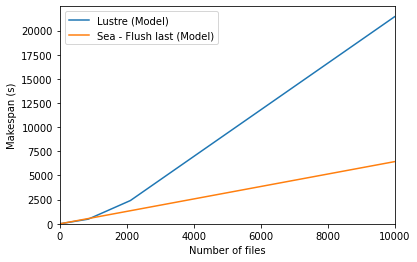

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nodes = 5
bw = 4*8
d = 6
i = 5
num_files = range(0, 10001)

lustre = [lpc_mksp(f, i, b, nodes, file_size, a_mem, n_threads, f*file_size, mem_r, dirty_ratio, mem_w) for f in num_files]
sea = [sea_mksp(f, i, b, nodes, file_size, n_threads, d) for f in num_files]


sns.lineplot(x=num_files, y=lustre, label="Lustre (Model)")
sns.lineplot(x=num_files, y=sea, label="Sea - Flush last (Model)")
#sns.scatterplot(data=df, x="disks", y="runtime", label="Sea- Flush last (Real)", color="orange")
plt.xlabel("Number of files")
plt.ylabel("Makespan (s)")
plt.xlim(0,10001)
plt.ylim(0)

### Model evaluation - Number of threads

(0.0, 832.5228676494249)

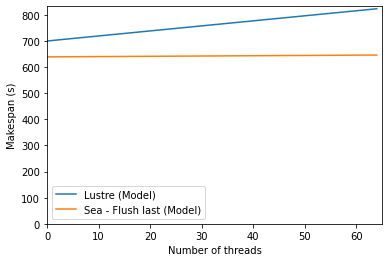

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nodes = 5
bw = 4*8
d = 6
i = 5
f = 1000
threads = range(0, 65)

lustre = [lpc_mksp(f, i, b, nodes, file_size, a_mem, t, f*file_size, mem_r, dirty_ratio, mem_w) for t in threads]
sea = [sea_mksp(f, i, b, nodes, file_size, t, d) for t in threads]


sns.lineplot(x=threads, y=lustre, label="Lustre (Model)")
sns.lineplot(x=threads, y=sea, label="Sea - Flush last (Model)")
#sns.scatterplot(data=df, x="disks", y="runtime", label="Sea- Flush last (Real)", color="orange")
plt.xlabel("Number of threads")
plt.ylabel("Makespan (s)")
plt.xlim(0,65)
plt.ylim(0)